In [49]:
%config IPCompleter.greedy=True

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import os

torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name() if torch_device.type == 'cuda' else 'cpu'
print(f'Using device: {device_name}, type {torch_device}')

Using device: cpu, type cpu


In [46]:
def load_cifar():
    train_transforms = [
        transforms.Pad(4, padding_mode='reflect'),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ]

    test_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ]

    cifar_train = datasets.CIFAR10('./datasets', train=True, download=True,
                                   transform=transforms.Compose(train_transforms))
    cifar_test = datasets.CIFAR10('./datasets', train=False, download=True,
                                  transform=transforms.Compose(test_transforms))

    batch_size = 256
    train_dataset = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dataset = DataLoader(cifar_test, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_dataset, test_dataset
train, test = load_cifar()

Files already downloaded and verified
Files already downloaded and verified


# Util Functions

In [47]:
def create_student(device):
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3)),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Conv2d(32, 64, kernel_size=(3, 3)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),
        nn.Linear(2304, 128),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(64, 10),
        nn.Softmax(dim=1)
    ).to(device)

def calc_accuracy(model, device):
    correct = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(test):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            pred_class = torch.argmax(preds, dim=1)
            correct += torch.eq(pred_class, labels).sum()
    return f'{(correct * 100) / len(test.dataset):.2f}%'

def list_files(dir_name):
    r = []
    for root, dirs, files in os.walk(dir_name):
        for name in files:
            r.append(os.path.join(root, name))
    return r

def parse_file_name(name):
    parts = name.split('_')
    # Returns the temperature and alpha values from the filename
    return parts[4][1:], parts[5][1:].replace('-', '.')[:-3]

# Plot temperature vs alpha heatmap

In [58]:
# Iterate over all files
# Skip any .pickle
# Load the model
    # Parse the filename
    # Store formatted data
    
student_model = create_student(torch_device)
d = {'alpha': [], 'temperature': [], 'acc': []}
all_files = list_files('../results/bst')
for i, file_name in enumerate(all_files):
    if file_name.endswith('pickle') or file_name.endswith('Store'):
        continue
    
    student_model.load_state_dict(torch.load(file_name, map_location=torch_device))
    student_model.eval()
    test_acc = calc_accuracy(student_model, torch_device)
    temperature, alpha = parse_file_name(file_name)
    d['alpha'].append(float(alpha))
    d['temperature'].append(int(temperature))
    d['acc'].append(float(test_acc) / 100)
    print(f'temp: {temperature}, alpha: {alpha}, test_acc: {test_acc}')

temp: 20, alpha: 0.9, test_acc: 72.43%
temp: 20, alpha: 0.5, test_acc: 75.58%
temp: 20, alpha: 0.1, test_acc: 77.49%
temp: 10, alpha: 0.9, test_acc: 72.67%
temp: 10, alpha: 0.1, test_acc: 78.14%
temp: 10, alpha: 0.5, test_acc: 76.57%
temp: 5, alpha: 0.9, test_acc: 73.42%
temp: 5, alpha: 0.1, test_acc: 77.99%
temp: 5, alpha: 0.5, test_acc: 76.73%
temp: 2, alpha: 0.1, test_acc: 77.28%
temp: 2, alpha: 0.5, test_acc: 76.44%
temp: 2, alpha: 0.9, test_acc: 74.93%
temp: 15, alpha: 0.1, test_acc: 78.02%
temp: 15, alpha: 0.5, test_acc: 76.13%
temp: 15, alpha: 0.9, test_acc: 72.93%
temp: 7, alpha: 0.9, test_acc: 74.27%
temp: 7, alpha: 0.1, test_acc: 77.56%
temp: 7, alpha: 0.5, test_acc: 76.27%


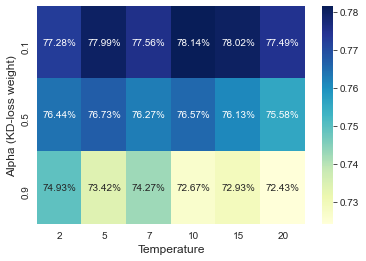

In [89]:
df = pd.DataFrame(data=d).sort_values('temperature')
result = df.pivot(index='alpha', columns='temperature', values='acc')

with sns.axes_style('white'):
    ax = sns.heatmap(result, annot=True, fmt='.2%', cmap='YlGnBu')
    ax.set(xlabel='Temperature', ylabel='Alpha (KD-loss weight)')
    plt.show()
    ax.get_figure().savefig('kd_temp_alpha.png', dpi=400)

# Other plots